In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import tensorflow.keras as keras
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout

In [2]:
# 얼리스탑핑 쉽게
def model_save_erstp(MODEL_SAVE_FOLDER_PATH, model_name, patience):
    save_file_name = model_name
    cb_checkpoint,cb_earlystopping = checkpoint_ez(MODEL_SAVE_FOLDER_PATH, save_file_name, patience)
    return cb_checkpoint,cb_earlystopping

def checkpoint_ez(MODEL_SAVE_FOLDER_PATH,save_file_name, patience) : 
    MODEL_SAVE_FOLDER_PATH = MODEL_SAVE_FOLDER_PATH
    data_name = save_file_name
    model_path = MODEL_SAVE_FOLDER_PATH + data_name + '.hdf5'
    # val_loss 값이 낮아졌을(좋아졌을) 때만 저장
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                    verbose=1, save_best_only=True
                                   )
    cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience = patience, verbose=1,
                                                  mode='auto', baseline=None, restore_best_weights=False)
    return cb_checkpoint, cb_earlystopping

# 그래프 쉽게
def loss_graph(label1,label2,bottom,top):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    loss_ax.plot(history.history['loss'], 'y', label=label1)
    loss_ax.plot(history.history['val_loss'], 'r', label=label2)
    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    # acc_ax.set_ylabel('accuray')
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')
    loss_ax.set_ylim(bottom,top)
    return plt.show()

# 모델 저장 def
def json_model_saver(MODEL_SAVE_FOLDER_PATH,file_name):
    # model save by json
    # load model 
    model = keras.models.load_model(MODEL_SAVE_FOLDER_PATH +file_name+ '.hdf5')
    # Save model with json format
    model_json = model.to_json()
    with open(MODEL_SAVE_FOLDER_PATH+file_name+'.json', "w") as json_file:
        json_file.write(model_json)
    # Save weight with h5 format
    model.save_weights( MODEL_SAVE_FOLDER_PATH +file_name +'.h5')
    return print("Saved model to disk : "+ file_name +'.h5')


In [3]:
# 데이터 불러오기
path_AL = '../9.data/0.work_data/3.Accident_list/'

AccList = pd.read_csv(path_AL + 'AccList.csv', header=None, index_col=0)

In [4]:
# Accident, Nonaccident 리스트 불러오기
diff_path = '../9.data/1.accData_split/1.diff_heatmap/'

acclist = os.listdir(diff_path + 'accident/')
nonacclist = os.listdir(diff_path + 'nonaccident/')

for i in range(len(acclist)):
    acclist[i] = acclist[i].split('.')[0]
for i in range(len(nonacclist)):
    nonacclist[i] = nonacclist[i].split('.')[0]

In [5]:
accData = AccList.loc[acclist]
accDataAmp = pd.concat([accData, accData, accData, accData, accData], axis=1)
nonaccData = AccList.loc[nonacclist]
nonaccDataAmp = pd.concat([nonaccData, nonaccData, nonaccData, nonaccData, nonaccData], axis=1)

In [6]:
colList = list(range(1,562))
accDataAmp = accDataAmp[colList]
nonaccDataAmp = nonaccDataAmp[colList]

accDataAmp['y'] = 1
nonaccDataAmp['y'] = 0
data = pd.concat([accDataAmp, nonaccDataAmp])

In [7]:
# 데이터 섞은 후 배열로 만들기

np.random.seed(0)
randomList = list(np.random.randint(2000, size = 2000))
data = data.reset_index(drop=True)
data = data.loc[randomList]
data = data.reset_index(drop=True)

In [8]:
dataX = data.T[:-1].T

scaler = MinMaxScaler()
scaler.fit(dataX)
dataX_scl = scaler.transform(dataX)

In [9]:
data = np.array(data)
dataX_scl = np.array(dataX_scl)

# input data 생성
nTrain = 1500
nTest = 500

x_train = dataX_scl[:nTrain, :561*5]
x_test = dataX_scl[:nTest, :561*5]
y_train = data[:nTrain, 561*5]
y_test = data[:nTest, 561*5]

In [10]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [11]:
# 데이터 reshape 및 차원 추가
x_train = x_train.reshape(x_train.shape[0],51,55)
x_train = np.expand_dims(x_train, -1)
x_test = x_test.reshape(x_test.shape[0],51,55)
x_test = np.expand_dims(x_test, -1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 49, 53, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 26, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 24, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 12, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 10, 32)         4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 640)              

104/120 [=========================>....] - ETA: 0s - loss: 0.6938 - accuracy: 0.4865
Epoch 00024: val_loss did not improve from 0.69075
120/120 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.4817 - val_loss: 0.6921 - val_accuracy: 0.5467
Epoch 25/1000
106/120 [=========================>....] - ETA: 0s - loss: 0.6941 - accuracy: 0.4792
Epoch 00025: val_loss did not improve from 0.69075
120/120 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.4900 - val_loss: 0.6915 - val_accuracy: 0.5467
Epoch 26/1000
107/120 [=========================>....] - ETA: 0s - loss: 0.6938 - accuracy: 0.4813
Epoch 00026: val_loss did not improve from 0.69075
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4867 - val_loss: 0.6920 - val_accuracy: 0.5467
Epoch 27/1000
107/120 [=========================>....] - ETA: 0s - loss: 0.6935 - accuracy: 0.5037
Epoch 00027: val_loss did not improve from 0.69075
120/120 [============

105/120 [=========================>....] - ETA: 0s - loss: 0.6937 - accuracy: 0.4905
Epoch 00053: val_loss did not improve from 0.69075
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.4933 - val_loss: 0.6908 - val_accuracy: 0.5467
Epoch 54/1000
107/120 [=========================>....] - ETA: 0s - loss: 0.6941 - accuracy: 0.4925
Epoch 00054: val_loss did not improve from 0.69075
120/120 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.4883 - val_loss: 0.6932 - val_accuracy: 0.4533
Epoch 55/1000
106/120 [=========================>....] - ETA: 0s - loss: 0.6933 - accuracy: 0.4934
Epoch 00055: val_loss did not improve from 0.69075
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4883 - val_loss: 0.6921 - val_accuracy: 0.5467
Epoch 56/1000
109/120 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5000
Epoch 00056: val_loss did not improve from 0.69075
120/120 [============

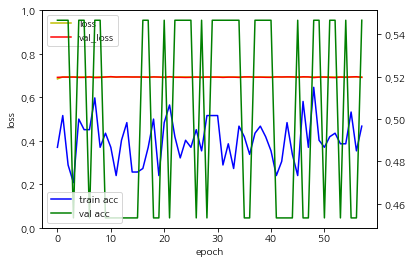

In [15]:
model_name = 'test'
MODEL_SAVE_FOLDER_PATH = '../1.model'
cb_checkpoint,cb_earlystopping = model_save_erstp(MODEL_SAVE_FOLDER_PATH, model_name, 50)

model = Sequential()
model.add(layers.Conv2D(filters=8, kernel_size = 3 , input_shape=(51,55,1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=16, kernel_size = 3, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size = 3, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dense(units=2, activation='sigmoid'))
model.compile(loss ='binary_crossentropy', optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, epochs=1000, batch_size=10, validation_split=0.2, callbacks=[cb_checkpoint,cb_earlystopping])
loss_graph('loss','val_loss',0,1)

In [16]:
loss, acc = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4780


In [198]:
y_test

,0.0,1.0
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
495,1,0
496,1,0
497,0,1
498,1,0


In [207]:
import matplotlib.pyplot as plt

plt.imshow(test[10])

NameError: name 'test' is not defined

In [121]:
test[0].shape

(51, 11)

In [120]:
img.shape

(1670, 2400, 3)

In [78]:
accPath = '../9.data/1.accData_split/1.diff_heatmap/accident/'
nonaccPath = '../9.data/1.accData_split/1.diff_heatmap/nonaccident/'

acc_list = os.listdir(accPath)
nonacc_list = os.listdir(nonaccPath)

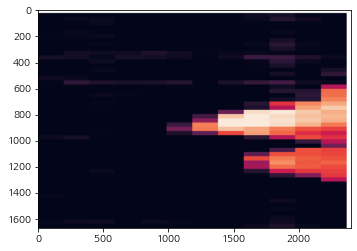

In [122]:
img = cv2.imread(accPath + acc_list[50])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [102]:
num = 0
for i in acc_list:    
    if num == 0:
        img = cv2.imread(accPath + i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x_train = np.expand_dims(img, 0)
        num += 1
    else:
        img = cv2.imread(accPath + i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(img, 0)
        x_train = np.concatenate((x_train, img), axis=0)


KeyboardInterrupt: 

TypeError: Invalid shape (1, 1670, 2400, 3) for image data

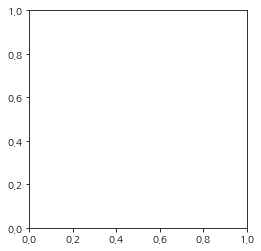

In [103]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [113]:
img = cv2.imread(accPath + acc_list[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)